In this document we are going to apply of the famous customer segmentation practices called RFM model on Amazon sales data
* The sales data include transactions between 03-Jan-2015 and 30-Dec-2018, so we will build this study as if today is 31-Dec-2018 (the day after the last transaction)
* We will consider only the trailing 18 months history


In [160]:
# load CSV data to DateFrame
import pandas as pd
import numpy as np

sales_df = pd.read_csv('data.csv')
sales_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [161]:
# Converting Order Date column to date
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], dayfirst=True)

In [162]:
# Snapshot date (The hypothetical "Today")
from datetime import datetime, timedelta

last_transaction_date = sales_df["Order Date"].max()
snapshot_date = last_transaction_date + timedelta(days=1)
print('Last Transaction Date :', last_transaction_date)
print('Snapshot Date :', snapshot_date)

Last Transaction Date : 2018-12-30 00:00:00
Snapshot Date : 2018-12-31 00:00:00


In [163]:
# Subset of trailing 18 months sales 
sales_last_18_months = sales_df[sales_df["Order Date"] >= datetime(2018, 12, 30) - timedelta(days=540)]

In [164]:
# Aggregating orders' lines
orders_last_18_months = sales_last_18_months.groupby(['Customer ID','Order ID', 'Order Date'])['Sales'].sum().reset_index()

In [165]:
# Now we populate recency, frequency and monetary columns for each column where
# Recency: number of days passed since the last customer purchase
# Frequency: number of purchases
# Monetary: Total customer's purchase in value we will call this column 'sales_Last_18_M'
# all of the above are for the last 18 months assuming today's date is 2018-12-31

datamart = orders_last_18_months.groupby("Customer ID").agg(
    recency=("Order Date", lambda x: (snapshot_date - x.max()).days),  # days passed since the last order
    frequency=("Order ID", "count"),                                   # number of orders during the period
    sales_Last_18_M=("Sales", "sum"),                                  # sales generated during the period
).reset_index()
datamart.head()

,Customer ID,recency,frequency,sales_Last_18_M
0,AA-10315,185,1,374.480
1,AA-10375,20,4,737.020
2,AA-10480,260,3,1763.052
3,AA-10645,56,2,304.700
4,AB-10015,416,1,563.940


In [166]:
# converting the above table into an Array type to use it in further steps
samples = datamart[['recency','frequency','sales_Last_18_M']].values

In [167]:
# In this step, we are going to cluster the 753 customers into 4 clusters using their RFM data
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=1)
km.fit(samples)
km.labels_[:10]

array([1, 1, 0, 1, 1, 2, 2, 1, 1, 1], dtype=int32)

In [168]:
datamart['cluster'] = km.labels_

In [169]:
colors = {0:'purple',1:'red',2:'teal'}
datamart['cluster_color'] = datamart['cluster'].map(colors)

In [175]:
customer_cluster_summary = (
    datamart.groupby(['cluster',"cluster_color"]).agg(
        Mean_Recency=("recency", "mean"),
        Mean_Frequency=("frequency", "mean"),
        Mean_Monetary=("sales_Last_18_M", "mean"),
        Customer_Count=("Customer ID", "count"),
        Total_Sales=("sales_Last_18_M", "sum"),
        Total_Sales_K=("sales_Last_18_M", lambda x: sum(x / 100)),
    ).round(1)
).reset_index()
customer_cluster_summary

,cluster,cluster_color,Mean_Recency,Mean_Frequency,Mean_Monetary,Customer_Count,Total_Sales,Total_Sales_K
0,0,purple,82.4,4.2,2698.8,189,510072.7,5100.7
1,1,red,132.4,2.8,658.6,535,352368.5,3523.7
2,2,teal,76.3,5.1,7695.8,29,223177.5,2231.8


In [176]:
r_line = datamart['recency'].mean()
f_line = datamart['frequency'].mean()
# customer_cluster_summary['Mean_Frequency'].mean()

In [177]:
f_line

np.float64(3.2802124833997346)

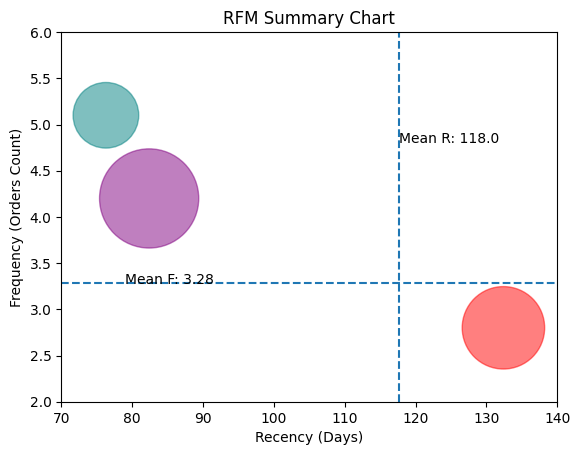

In [183]:
import matplotlib.pyplot as plt

# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster', s='sales_Last_18_M')
# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster')
plt.scatter(
    data=customer_cluster_summary,
    x="Mean_Recency",
    y="Mean_Frequency",
    s="Total_Sales_K",
    c=colors.values(),
    alpha=0.5,
)
plt.title("RFM Summary Chart")
plt.axhline(y=f_line, linestyle="--", label="Mean F=" + str(f_line))
plt.axvline(x=r_line, linestyle="--", label="Mean R=" + str(r_line))
plt.text(x=79, y=f_line, s="Mean F: " + str(round(f_line, 2)))
plt.text(x=r_line, y=4.8, s="Mean R: " + str(round(r_line, 0)))
# plt.legend()
plt.xlim(70, 140)
plt.ylim(2, 6)
plt.xlabel("Recency (Days)")
plt.ylabel("Frequency (Orders Count)")
plt.show()

* After we clustered the 753 customers using KMeans, we got the mean of Recency, Frequency and Monetary of each cluster.
The above chart presents the Recency on the x axis, Frequency on the y axis and then the bubble size corresponds to the third element which is Monetary.
* The two crossed blue lines illustrates the means of the R & F
* The two bubbles on the top left area present those classes with a relative high frequency and low recency of orders, in contrary the red bubble shows high recency and a low frequency of orders, their details are brokendown below

In [174]:
customer_cluster_summary

,cluster,cluster_color,Mean_Recency,Mean_Frequency,Mean_Monetary,Customer_Count,Total_Sales,Total_Sales_K
0,0,purple,82.4,4.2,2698.8,189,510072.7,510.1
1,1,red,132.4,2.8,658.6,535,352368.5,352.4
2,2,teal,76.3,5.1,7695.8,29,223177.5,223.2


The above table shows that the largest cluster, in terms of customers count, is the red one, and the total sales generate from this cluster presents 32% of the total sales